In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
from os.path import expanduser

In [2]:
PROTON_MASS = 1.00727647
ADD_C_CYSTEINE_DA = 57.021464

In [3]:
# calculate the monoisotopic mass    
def calculate_monoisotopic_mass_from_mz(monoisotopic_mz, charge):
    monoisotopic_mass = (monoisotopic_mz * charge) - (PROTON_MASS * charge)
    return monoisotopic_mass

In [4]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
precursor_definition_method = 'pasef'
experiment_base_dir = '/media/big-ssd/experiments'

In [5]:
EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)
MQ_PERCOLATOR_OUTPUT_DIR = '{}/percolator-output-pasef-maxquant'.format(EXPERIMENT_DIR)

In [6]:
MAXIMUM_Q_VALUE = 0.01

In [7]:
# load the percolator output
MQ_PERCOLATOR_OUTPUT_FILE_NAME = "{}/{}.percolator.target.psms.txt".format(MQ_PERCOLATOR_OUTPUT_DIR, experiment_name)
mq_psms_df = pd.read_csv(MQ_PERCOLATOR_OUTPUT_FILE_NAME, sep='\t')
mq_psms_df.rename(columns={'scan': 'mq_index'}, inplace=True)
mq_psms_df.drop(['charge'], axis=1, inplace=True)
# remove the poor quality identifications
mq_psms_df = mq_psms_df[mq_psms_df['peptide mass'] > 0]

In [8]:
mq_psms_df.columns

Index(['file_idx', 'mq_index', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa'],
      dtype='object')

In [9]:
# merge the precolator results with the MQ features
MQ_FEATURES_NAME = '{}/MQ-analysis-of-P3856/combined/P3856_YHE211_1_Slot1-1_1_5104-dwm.pkl'.format(expanduser('~'))
mq_features_df = pd.read_pickle(MQ_FEATURES_NAME)

In [10]:
mq_features_df.columns

Index(['monoisotopic_mass', 'charge', 'monoisotopic_mz', 'intensity',
       'scan_apex', 'rt_apex', 'raw_file', 'mq_index', 'ms2_peaks'],
      dtype='object')

In [11]:
mq_identifications_df = pd.merge(mq_features_df, mq_psms_df, how='left', left_on=['mq_index'], right_on=['mq_index'])
# remove any features that were not identified
mq_identifications_df.dropna(subset=['sequence'], inplace=True)


In [12]:
mq_identifications_df['theoretical_peptide_mass'] = mq_identifications_df['peptide mass'] + (mq_identifications_df.sequence.str.count('C') * ADD_C_CYSTEINE_DA)
mq_identifications_df['mass_accuracy_ppm'] = (mq_identifications_df['monoisotopic_mass'] - mq_identifications_df['theoretical_peptide_mass']) / mq_identifications_df['theoretical_peptide_mass'] * 10**6
mq_identifications_df['mass_error'] = mq_identifications_df['monoisotopic_mass'] - mq_identifications_df['theoretical_peptide_mass']


In [13]:
mq_identifications_df.columns

Index(['monoisotopic_mass', 'charge', 'monoisotopic_mz', 'intensity',
       'scan_apex', 'rt_apex', 'raw_file', 'mq_index', 'ms2_peaks', 'file_idx',
       'spectrum precursor m/z', 'spectrum neutral mass', 'peptide mass',
       'percolator score', 'percolator q-value', 'percolator PEP',
       'total matches/spectrum', 'sequence', 'protein id', 'flanking aa',
       'theoretical_peptide_mass', 'mass_accuracy_ppm', 'mass_error'],
      dtype='object')

In [14]:
mq_sequences_l = []
for group_name,group_df in mq_identifications_df.groupby(['sequence','charge'], as_index=False):
    if group_df['percolator q-value'].min() <= MAXIMUM_Q_VALUE:
        mq_index = group_df.loc[group_df['percolator q-value'].idxmin()].mq_index
        score = group_df['percolator score'].max()
        mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
        mq_sequences_l.append({'sequence_key':'{}-{}'.format(group_name[0], group_name[1]), 'mq_index':mq_index, 'score':score, 'mass_accuracy_ppm':mass_accuracy_ppm})
mq_sequences_df = pd.DataFrame(mq_sequences_l)

In [15]:
mq_sequences_df.sample(n=3)

,sequence_key,mq_index,score,mass_accuracy_ppm
1663,EVWNTYELDLVNYQNK-2,16632,0.622790,-1.134702
3478,LAGTESPVREEPGEDFPAAR-2,18241,0.051199,-1.316394
4025,LPDSALDLVDISCAGVAVAR-2,16875,0.893891,-1.403198


In [16]:
# load my identifications
BASE_RESULTS_DIR = '/media/data-4t-a/results-P3856/cs-true-fmdw-true-2021-09-30-06-51-55/P3856'
IDENTS_DIR = '{}/identifications-{}'.format(BASE_RESULTS_DIR, precursor_definition_method)
IDENTS_NAME = '{}/exp-{}-identifications-{}-recalibrated.feather'.format(IDENTS_DIR, experiment_name, precursor_definition_method)

In [17]:
identifications_before_unique_df = pd.read_feather(IDENTS_NAME)

In [18]:
sequences_l = []
for group_name,group_df in identifications_before_unique_df.groupby(['sequence','charge'], as_index=False):
    if group_df['percolator q-value'].min() <= MAXIMUM_Q_VALUE:
        feature_id = int(group_df.loc[group_df['percolator q-value'].idxmin()].feature_id)
        score = group_df['percolator score'].max()
        mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
        sequences_l.append({'sequence_key':'{}-{}'.format(group_name[0], group_name[1]), 'feature_id':feature_id, 'score':score, 'mass_accuracy_ppm':mass_accuracy_ppm})
sequences_df = pd.DataFrame(sequences_l)

In [19]:
sequences_df.sample(n=3)

,sequence_key,feature_id,score,mass_accuracy_ppm
2172,EECLQFTANALALAMER-2,4142901,1.226689,-1.528994
11664,VHVTQEDFEMAVAK-2,1377701,1.494849,-0.441969
6122,LDGGNAYAGATISPHYDSMLVK-3,2204501,0.088705,2.719691


In [20]:
common_df = pd.merge(mq_sequences_df, sequences_df, how='inner', left_on=['sequence_key'], right_on=['sequence_key'], suffixes=['_mq','_tfde'])


In [21]:
common_df.columns

Index(['sequence_key', 'mq_index', 'score_mq', 'mass_accuracy_ppm_mq',
       'feature_id', 'score_tfde', 'mass_accuracy_ppm_tfde'],
      dtype='object')

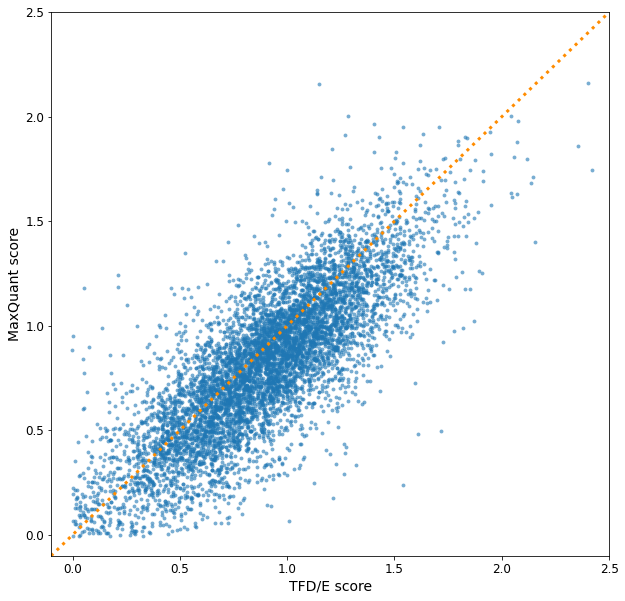

In [29]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
# plt.title('percolator score of peptides identified from MaxQuant and TFD/E')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.scatter(common_df.score_tfde, common_df.score_mq, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=3, color='darkorange')

plt.xlim((-0.1,2.5))
plt.ylim((-0.1,2.5))

plt.xlabel('TFD/E score', fontsize=14)
plt.ylabel('MaxQuant score', fontsize=14)

plt.show()

/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


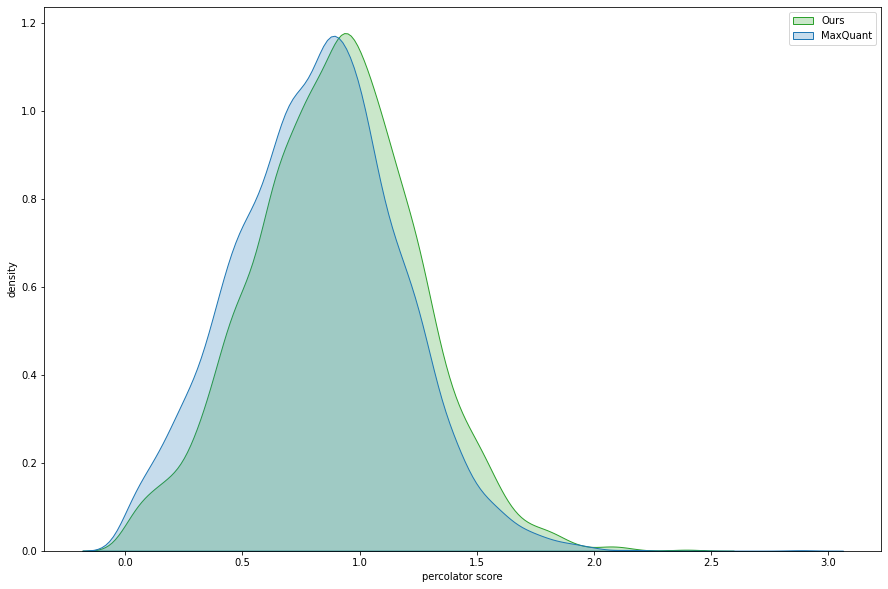

In [23]:
import seaborn as sns
plt.figure(figsize=(15, 10))

# title = 'density of the percolator score of identified features with and without mass defect window filtering'
# plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(common_df.score_tfde, hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Ours')
_ = sns.distplot(common_df.score_mq, hist = False, color='tab:blue', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'MaxQuant')

_ = ax.set(xlabel='percolator score', ylabel='density')
_ = ax.legend()

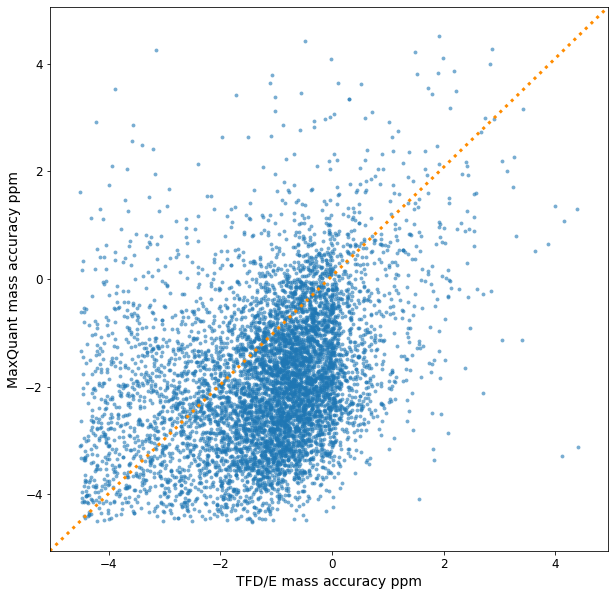

In [30]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
# plt.title('mass accuracy ppm of peptides identified from MaxQuant and TFD/E')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax.scatter(common_df.mass_accuracy_ppm_tfde, common_df.mass_accuracy_ppm_mq, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=3, color='darkorange')

# plt.xlim((-0.1,2.5))
# plt.ylim((-0.1,2.5))

plt.xlabel('TFD/E mass accuracy ppm', fontsize=14)
plt.ylabel('MaxQuant mass accuracy ppm', fontsize=14)

plt.show()

/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/daryl/anaconda3/envs/py36/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


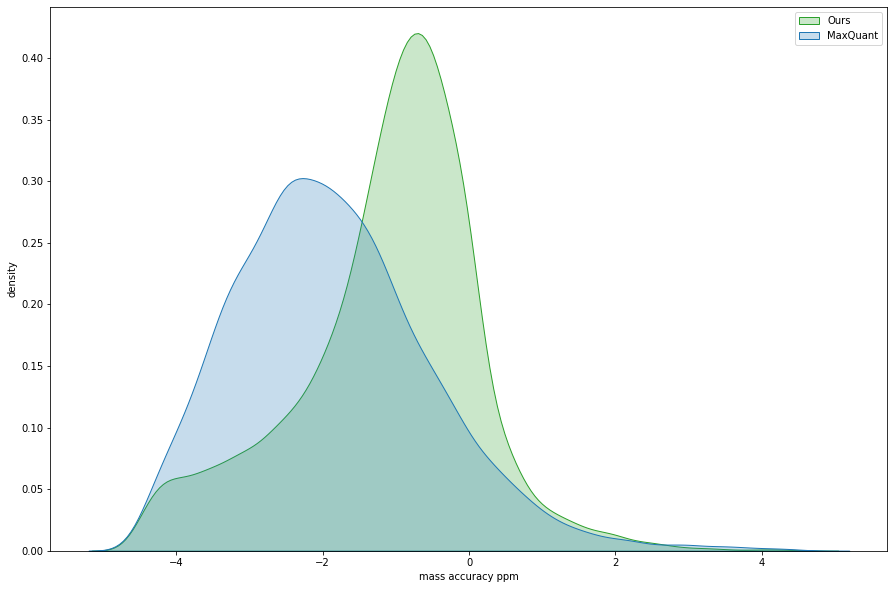

In [25]:
import seaborn as sns
plt.figure(figsize=(15, 10))

# title = 'density of the percolator score of identified features with and without mass defect window filtering'
# plt.title(title)

# plt.xlim((-4,4))
# plt.ylim((0,1))

ax = sns.distplot(common_df.mass_accuracy_ppm_tfde, hist = False, color='tab:green', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'Ours')
_ = sns.distplot(common_df.mass_accuracy_ppm_mq, hist = False, color='tab:blue', kde = True, kde_kws = {'shade': True, 'linewidth': 1}, label = 'MaxQuant')

_ = ax.set(xlabel='mass accuracy ppm', ylabel='density')
_ = ax.legend()